In [1]:
import pandas as pd
from google.cloud import bigquery
from matplotlib import pyplot as plt
from settings import DATA_DIR, RUN_QUERIES
from ipywidgets import interact_manual
from adapters.repository import DataFrameRepository
from content.controls.control import TVRadio
from options.interactive import set_interactive_opts
from options.pandas import set_pandas_opts
from options.plot import set_plot_opts
from content.sql_queries import broadcast_tv_radio_station
from IPython.core.display import display, clear_output
import geopandas as gpd

In [2]:
set_pandas_opts()
set_plot_opts()
set_interactive_opts()

### Table of Contents <a name="toc"></a>
* [SQL Query](#sql-query)
* [SQL Execution](#sql-execution)
* [Sample Data](#sample-data)
* [Distribution Plot](#distribution-plot)
* [Something Else](#something-else)


### SQL Query <a name="sql-query"></a>
Check out the radio station distribution in the US

[back to top](#toc)

In [3]:
print(broadcast_tv_radio_station.sql_command)


SELECT 
    communityState,
    INITCAP(communityCity) as communityCity,
    service,
    status,
    COUNT(DISTINCT stationId) AS number_of_stations
FROM `bigquery-public-data.fcc_political_ads.broadcast_tv_radio_station` 
GROUP BY communityState, communityCity, service, status



### SQL Execution <a name="sql-execution"></a>

[back to top](#toc)

In [4]:
dfr = DataFrameRepository(repository_path=DATA_DIR)

bigquery_client = bigquery.Client()
RUN_QUERIES = False
broadcast_tv_radio_station_df: pd.DataFrame
if RUN_QUERIES:
    broadcast_tv_radio_station_df = bigquery_client.query(query=broadcast_tv_radio_station.sql_command).to_dataframe()
    dfr.add(data_frame=broadcast_tv_radio_station_df, filename='broadcast_tv_radio_station.fth')
else:
    broadcast_tv_radio_station_df = dfr.get('broadcast_tv_radio_station.fth')


### Sample Data <a name="sample-data"></a>

[back to top](#toc)

Broadcast tv/radio stations

In [5]:
display(broadcast_tv_radio_station_df.head(3))

,communityState,communityCity,service,status,number_of_stations
0,MO,St. Louis,Digital TV,LICENSED,6
1,CA,Mecca,FM Station,LICENSED,3
2,PR,Rio Grande,FM Station,LICENSED,1


Latitudes and longitudes for each city and state

In [6]:
geolocation_df = pd.read_csv('../content/data/uscities.csv')
geolocation_df[['city',
                'state_id',
                'state_name',
                'lat',
                'lng']].head(3)

,city,state_id,state_name,lat,lng
0,New York,NY,New York,40.6943,-73.9249
1,Los Angeles,CA,California,34.1139,-118.4068
2,Chicago,IL,Illinois,41.8373,-87.6862


Join the dots

In [7]:
result_df = broadcast_tv_radio_station_df.merge(
    geolocation_df,
    how='inner',
    left_on=['communityCity', 'communityState'],
    right_on=['city', 'state_id']
)

result_df = result_df[['city',
                       'state_name',
                       'lat',
                       'lng',
                       'service',
                       'status',
                       'number_of_stations']]

result_df.head(3)

,city,state_name,lat,lng,service,status,number_of_stations
0,St. Louis,Missouri,38.6358,-90.2451,Digital TV,LICENSED,6
1,St. Louis,Missouri,38.6358,-90.2451,Digital Class A TV,LICENSED,1
2,St. Louis,Missouri,38.6358,-90.2451,FM Station,LICENSED,9


### High Level Aggregation <a name="high-level"></a>

[back to top](#toc)

In [8]:
high_level_df = result_df.groupby(['state_name']).aggregate('number_of_stations').sum()
high_level_df = pd.DataFrame(high_level_df).reset_index()
high_level_df.head(3)

,state_name,number_of_stations
0,Alabama,409
1,Alaska,201
2,Arizona,288


In [9]:
tv_radio = TVRadio(data_frame=high_level_df)

In [10]:
#TODO: add a plot
@interact_manual
def show_high_level(min_stations=tv_radio.min_stations,
                    max_stations=tv_radio.max_stations):

    display(
        high_level_df[
                (high_level_df['number_of_stations'] > min_stations)
                & (high_level_df['number_of_stations'] <= max_stations)
        ].sort_values(by='number_of_stations', ascending=False)
        #.style.hide_index()
    )

interactive(children=(IntSlider(value=1, description='min_stations', max=1249, min=1), IntSlider(value=624, de…

### A Little More Detail <a name="a-little-more-detail"></a>

[back to top](#toc)

In [11]:
tv_radio = TVRadio(data_frame=result_df)
display(tv_radio.service, tv_radio.licence_status, tv_radio.state_names)

array(['AM Station', 'Digital Class A TV', 'Digital TV', 'FM Station'],
      dtype=object)

array(['LICENSED', 'LICENSED AND SILENT'], dtype=object)

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [12]:
#TODO: add a plot
@interact_manual
def do_something(state_name = tv_radio.state_names,
                 licence_status = tv_radio.licence_status,
                 service = tv_radio.service,):
    display(
        result_df[
            (result_df['state_name'] == state_name)
            & (result_df['status'] == licence_status)
            & (result_df['service'] == service)
        ]
    )

interactive(children=(Dropdown(description='state_name', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', …

### Distribution <a name="distribution"></a>

[back to top](#toc)


In [13]:
from content.plots import distribution
distribution.display(tv_radio=tv_radio, data_frame=result_df)

interactive(children=(Dropdown(description='service', options=('AM Station', 'Digital Class A TV', 'Digital TV…

### Add map <a name="add-map"></a>

[back to top](#toc)

<AxesSubplot:>

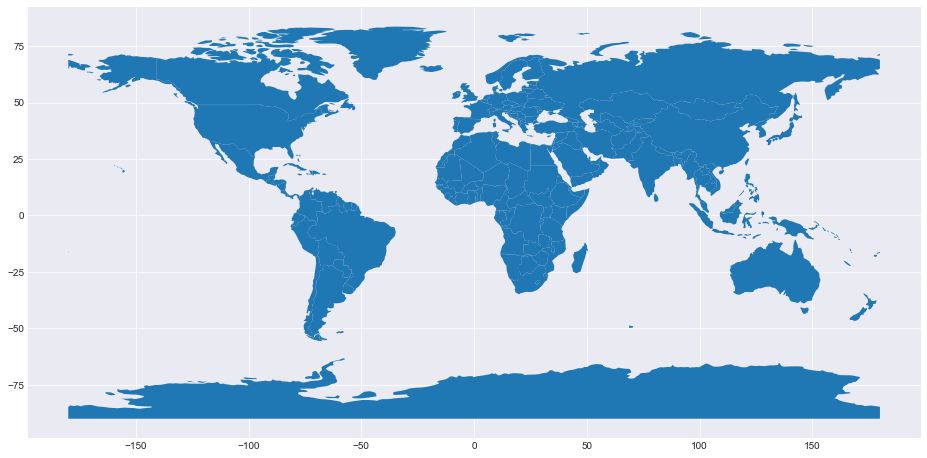

In [14]:
#TODO: add some metrics on the map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.plot()

### The End